# Global mean Sea Surface Temperatures

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

from calendar import monthrange

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.dates import DateFormatter

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

from shapely.geometry import Polygon, Point
from shapely.ops import transform
import pyproj

from globales import *
plt.rcParams['figure.figsize'] = (10, 4)

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=26, threads_per_worker=1)
client = Client(cluster)

/opt/conda/envs/ocean/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43739 instead
  warnings.warn(


2025-05-23 13:44:48,957 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2025-05-23 13:45:01,110 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2025-05-23 13:45:12,877 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2025-05-23 13:46:00,374 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2025-05-23 13:46:16,639 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2025-05-23 13:51:32,681 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2025-05-23 13:58:16,025 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:35221' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('rechunk-split-8c07adb0869850

In [3]:
client.dashboard_link

'http://127.0.0.1:43739/status'

## Load data

In [4]:
base_file = GlobalSU['DatPath'] + '/Satelite/MUR/NC/'

In [5]:
year1= 2003
year2= 2024
files = []
for iy in range(year1,year2+1):
    for im in range(1,13):
        for id in range(1,monthrange(iy,im)[1]+1):
            files.append(base_file+"%04d%02d%02d090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc"%(iy,im,id))

In [6]:
def drop_coords(ds):
    ds = ds.get(['analysed_sst'])
    return ds.reset_coords(drop=True)

DS = xr.open_mfdataset(files,combine='nested', 
                            concat_dim="time", parallel=True, combine_attrs= "drop", preprocess=drop_coords,autoclose = True, data_vars='minimal', coords="minimal")

## Indico la EBUS

In [ ]:
Region='CaCLME'
lon_min=-25
lon_max=-5
lat_min=10
lat_max=45

Region='HuCLME'
lon_min=-90
lon_max=-70
lat_min=-45
lat_max=-10

Region='BeCLME'
lon_min=0
lon_max=20
lat_min=-45
lat_max=-10

Region='ClCLME'
lon_min=-130
lon_max=-110
lat_min=10
lat_max=45


In [9]:
sst=DS.analysed_sst.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))-273.15

In [10]:
sstp=sst[-1,:,:].load()

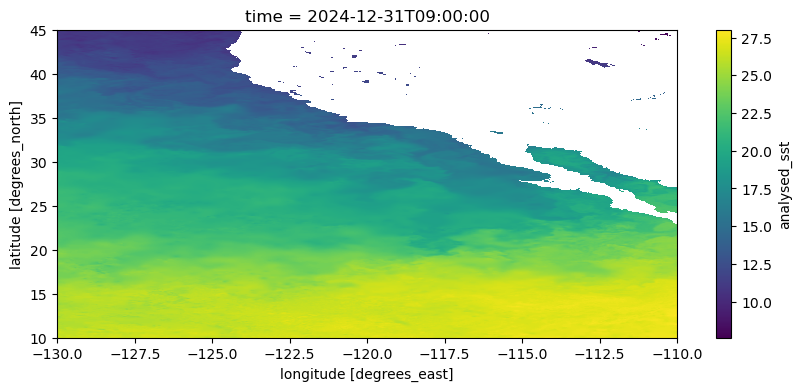

In [11]:
sstp.plot()

2025-05-23 13:42:38,862 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2025-05-23 13:42:49,622 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2025-05-23 13:42:59,480 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


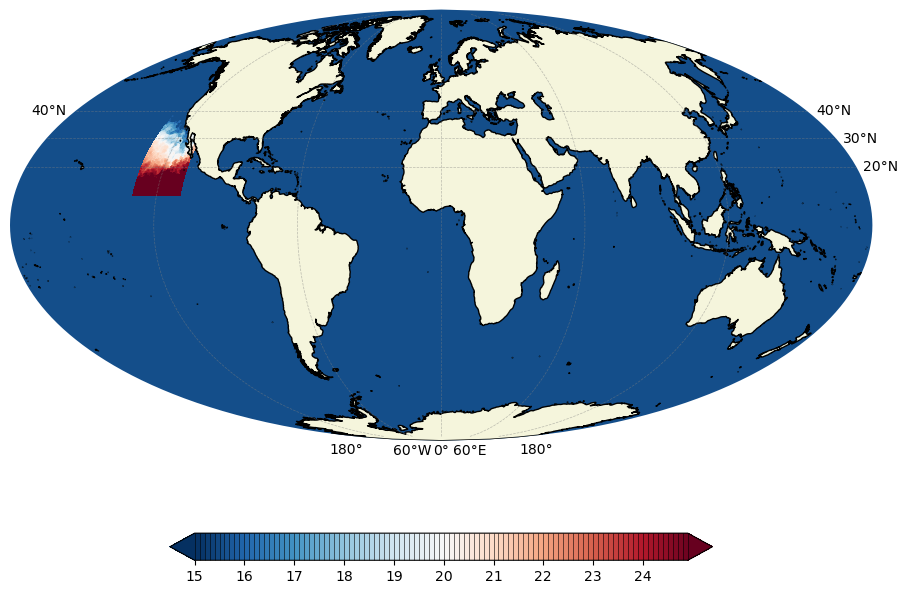

In [13]:
fig= plt.figure(figsize=(14,8))

ax = plt.axes(projection=ccrs.Mollweide(),frameon=False)
ax.patch.set_visible(False)

land = cartopy.feature.NaturalEarthFeature('physical', 'land', 
                        edgecolor='k', 
                        scale = '50m' ,facecolor=cfeature.COLORS['land'])
ax.add_feature(land, facecolor='beige')
        
cm=ax.contourf(sstp.lon,sstp.lat,sstp, levels=np.arange(15,25,0.1), 
               transform=ccrs.PlateCarree(),
               cmap = plt.cm.RdBu.reversed(),
               vmin = 15,vmax = 25,extend='both')

gridlines=ax.gridlines(draw_labels=True, linewidth=.5,color='gray', alpha=0.5, linestyle='--',x_inline=False, y_inline=False)
gridlines.ylocator = mticker.FixedLocator([20, 30, 40])
#gridlines.xlocator = mticker.FixedLocator([-19, -14, -9])
gridlines.left_labels = False
gridlines.top_labels = False

cbar=fig.colorbar(cm,ax=ax, location='bottom',shrink=.5, drawedges=True)



In [15]:
sst_re = sst.chunk({"time":8036, "lat":10, "lon":100})

2025-05-23 13:43:53,382 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


In [16]:
sst_re




<xarray.DataArray 'analysed_sst' (time: 8036, lat: 3501, lon: 2001)> Size: 450GB
dask.array<rechunk-merge, shape=(8036, 3501, 2001), dtype=float64, chunksize=(8036, 10, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 64kB 2003-01-01T09:00:00 ... 2024-12-31T09...
  * lat      (lat) float32 14kB 10.0 10.01 10.02 10.03 ... 44.98 44.99 45.0
  * lon      (lon) float32 8kB -130.0 -130.0 -130.0 ... -110.0 -110.0 -110.0

In [17]:
z=sst_re.polyfit('time',deg=1).compute() 

2025-05-23 13:44:04,684 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2025-05-23 13:44:21,944 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2025-05-23 13:44:29,986 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2025-05-23 13:44:42,070 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
/opt/conda/envs/ocean/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 54.29 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2025-05-23 13:58:18,745 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:35221
Traceback (most recent call last):
  File "/opt/conda/envs/ocean/lib/python3.11/site-packages/distributed/comm/tcp.py", line 2

In [18]:
Slope=z.polyfit_coefficients[0,:,:]/1.e-9*24*3600*365*100
Slope

<xarray.DataArray 'polyfit_coefficients' (lat: 3501, lon: 2001)> Size: 56MB
array([[2.90747422, 2.91853648, 2.92991412, ..., 2.51020981, 2.51563279,
        2.52269626],
       [2.9102438 , 2.9220718 , 2.93304274, ..., 2.51196697, 2.51633119,
        2.52333516],
       [2.91152073, 2.92443109, 2.93615338, ..., 2.51633822, 2.51839536,
        2.52417594],
       ...,
       [4.79274222, 4.78527179, 4.77880849, ...,        nan,        nan,
               nan],
       [4.80087436, 4.79228947, 4.78421031, ...,        nan,        nan,
               nan],
       [4.80971612, 4.80056933, 4.79119571, ...,        nan,        nan,
               nan]])
Coordinates:
  * lat      (lat) float32 14kB 10.0 10.01 10.02 10.03 ... 44.98 44.99 45.0
  * lon      (lon) float32 8kB -130.0 -130.0 -130.0 ... -110.0 -110.0 -110.0
    degree   int64 8B 1

In [19]:
Slope.to_netcdf('./data2/TendenciasMUR_'+Region+'.nc')

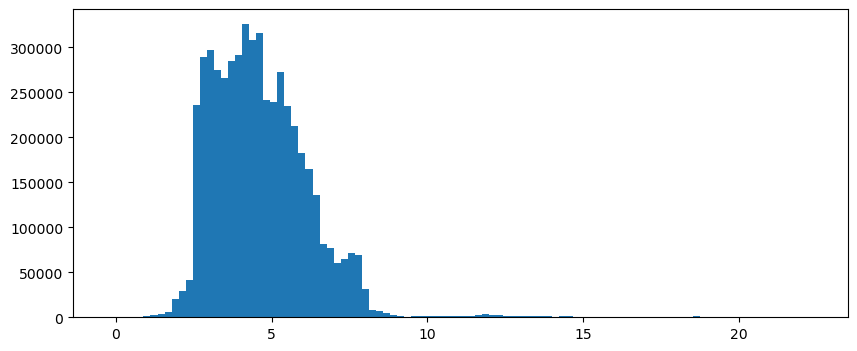

In [20]:
plt.hist(Slope.values.flatten(),bins=100);

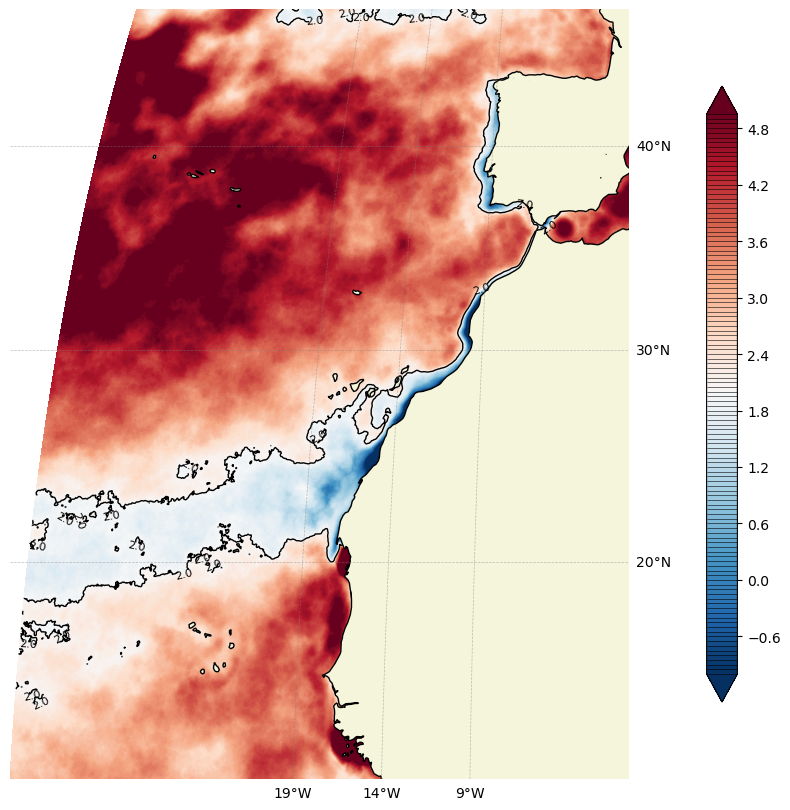

In [ ]:
fig= plt.figure(figsize=(20,10))

ax = plt.axes(projection=ccrs.Mollweide(),frameon=False)
ax.patch.set_visible(False)

land = cartopy.feature.NaturalEarthFeature('physical', 'land', edgecolor='k', scale = '50m' ,
            facecolor=cfeature.COLORS['land'])
ax.add_feature(land, facecolor='beige')
        
cm=ax.contourf(Slope.lon,Slope.lat,Slope, 
               levels=np.arange(-1,5,0.05), 
               transform=ccrs.PlateCarree(),
               cmap = plt.cm.RdBu.reversed(),
               vmin = -1,vmax = 5,extend='both')

contour_lines = ax.contour(Slope.lon, Slope.lat, Slope,
                           levels=[2],  # Adjust the step size for isolines
                           colors='black', linewidths=1,
                           transform=ccrs.PlateCarree())

ax.clabel(contour_lines, inline=True, fontsize=8, fmt="%1.1f")

Gd=ax.gridlines(draw_labels=True, linewidth=.5,color='gray', alpha=0.5, linestyle='--',x_inline=False, y_inline=False)
Gd.ylocator = mticker.FixedLocator([20, 30, 40])
Gd.xlocator = mticker.FixedLocator([-19, -14, -9])
Gd.left_labels = False
Gd.top_labels = False

cbar=fig.colorbar(cm,ax=ax,shrink=.8, drawedges=True,location='right')

In [ ]:
Gd.xlocator = mticker.FixedLocator([-30, -20, -10, 0])

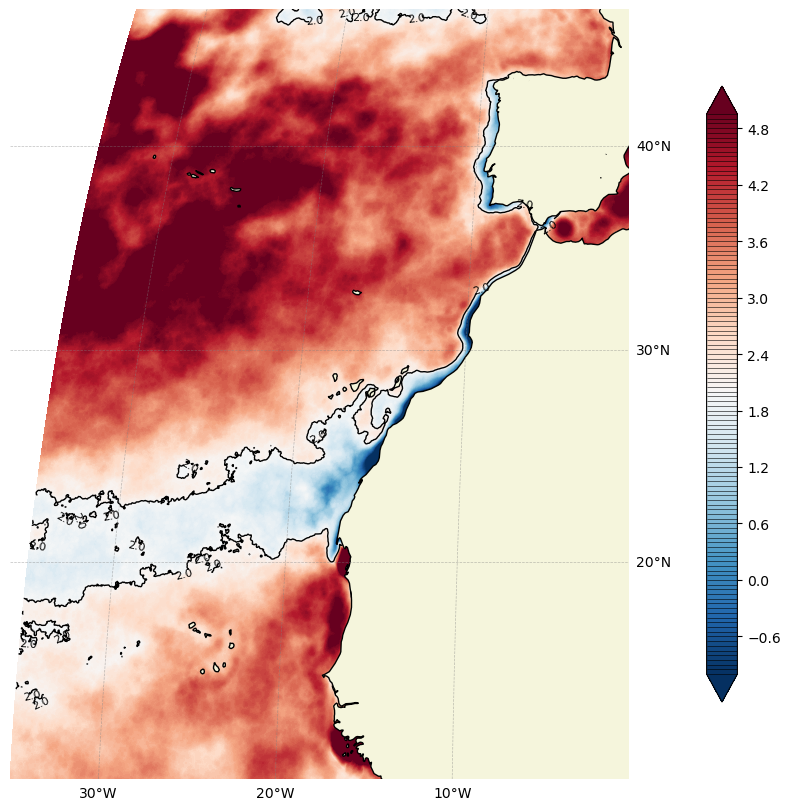

In [ ]:
fig